In [98]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import h5py
from tensorflow.python.framework import ops
%matplotlib inline

In [107]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.01, num_epochs=1500, minibatch_size=32, print_cost=True):
    
    ops.reset_default_graph() 
    (n_x, m) = X_train.shape
    n_y = Y_train.shape[0]
    costs = []
    
    #STEP1: Create placeholders for X and Y
    X, Y = create_placeholders(n_x, n_y)
    
    #STEP2: Initialize Parameters
    parameters = initialize_parameters()
    
    #STEP3: Forward Propagation
    ZL = forward_propagation(X, parameters)
    
    #STEP4: Calculate the cost
    cost = compute_cost(ZL, Y)
    
    #STEP5: Back Propagation
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
    
    #STEP6: Run the session
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            epoch_cost = 0.
            num_minibatches = int(m/minibatch_size)
            minibatches = random_minibatchs(X_train, Y_train, minibatch_size)
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _, minibatch_cost = sess.run([optimizer, cost], feed_dict = {X:minibatch_X, Y:minibatch_Y})
                epoch_cost += minibatch_cost/num_minibatches
            
            if print_cost==True and epoch%100==0:
                print("Cost at epoch " + str(epoch) + " is " + str(epoch_cost))
            if epoch%5 ==0:
                costs.append(epoch_cost)
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        #STEP7: Store the value of parameters in a variable
        parameters = sess.run(parameters)
        
        #STEP8: Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(ZL), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

# Readying the Data

In [108]:
#Input Data
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

In [111]:
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T

X_train = X_train_flatten/255
X_test = X_test_flatten/255

Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

# Run the model

Cost at epoch 0 is 2.12666006161
Cost at epoch 100 is 1.84635958888
Cost at epoch 200 is 1.84636949409
Cost at epoch 300 is 1.84638529474
Cost at epoch 400 is 1.846330556
Cost at epoch 500 is 1.84632841746
Cost at epoch 600 is 1.84640319058
Cost at epoch 700 is 1.84636721105
Cost at epoch 800 is 1.84632278572
Cost at epoch 900 is 1.8463880221
Cost at epoch 1000 is 1.84641027812
Cost at epoch 1100 is 1.84632664016
Cost at epoch 1200 is 1.84635640636
Cost at epoch 1300 is 1.8463482351
Cost at epoch 1400 is 1.84640120737


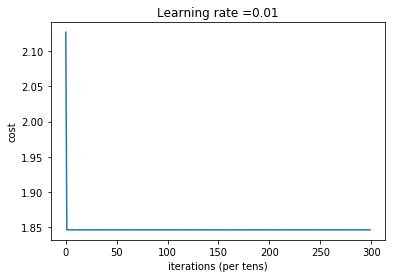

Train Accuracy: 0.166667
Test Accuracy: 0.166667


In [110]:
# nn_layers = np.array([12288, 25, 12, 6])
tf.reset_default_graph()
parameters = model(X_train, Y_train, X_test, Y_test)

# Supporting Functions

In [103]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder(shape=[n_x,None],dtype='float')
    Y = tf.placeholder(shape=[n_y,None],dtype='float')
#     X = tf.placeholder(tf.float32)
#     Y = tf.placeholder(tf.float32)
    return X, Y

In [75]:
# def initialize_parameters(nn_layers):
#     parameters = {}
#     L = len(nn_layers)
#     for l in range(L):
#         parameters["W" + str(l+1)] = tf.get_variable(parameters["W" + str(l+1)],[nn_layers[l], nn_layers[l-1]], initializer=tf.contrib.layers.xavier_initializer())
#         parameters["b" + str(l+1)] = tf.get_variable(parameters["b" + str(l+1)], [nn_layers[l], nn_layers[l-1]], initializer=tf.contrib.layers.xavier_initializer())
#     return parameters

In [76]:
def initialize_parameters():
    
    W1 = tf.get_variable('W1',[25,12288],initializer=tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable('b1',[25,1],initializer=tf.zeros_initializer())
    W2 = tf.get_variable('W2',[12,25],initializer=tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable('b2',[12,1],initializer=tf.zeros_initializer())
    W3 = tf.get_variable('W3',[6,12],initializer=tf.contrib.layers.xavier_initializer())
    b3 = tf.get_variable('b3',[6,1],initializer=tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [77]:
# def forward_propagation(X, parameters):
#     L = len(parameters)//2
#     A = X
#     for l in range(L):
#         A_prev = A
#         Z = tf.add(tf.matmul(parameters["W" + str(l+1)], A_prev), parameters["b" + str(l+1)])
#         A = tf.nn.relu(Z)
#     return Z

In [97]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1,X),b1)                                 
    A1 = tf.nn.relu(Z1)                                            
    Z2 = tf.add(tf.matmul(W2,A1),b2)                                             
    A2 = tf.nn.relu(Z2)                                            
    Z3 = tf.add(tf.matmul(W3,Z2),b3)                                           
    
    return Z3

In [78]:
def compute_cost(Z, Y):
    logits = tf.transpose(Z)
    labels = tf.transpose(Y)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    return cost

In [79]:
def random_minibatchs(X, Y, minibatch_size=64):
    m = X.shape[1]
    num_complete_batches = math.floor(m/minibatch_size)
    minibatches = []
    
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0], m))
    
    for k in range(num_complete_batches):
        mini_batch_X = shuffled_X[:, k*minibatch_size:(k+1)*minibatch_size]
        mini_batch_Y = shuffled_Y[:, k*minibatch_size:(k+1)*minibatch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        minibatches.append(mini_batch)
    
    if m%minibatch_size!=0:
        mini_batch_X = shuffled_X[:, num_complete_batches * minibatch_size:]
        mini_batch_Y = shuffled_Y[:, num_complete_batches * minibatch_size:]
        minibatch = (mini_batch_X, mini_batch_Y)
        minibatches.append(minibatch)
    
    return minibatches

In [80]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [81]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y